In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from cmath import isinf
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pandas as pd
import math
from utils_v import compute_age_mae_r2, estimate_age
from cmath import isinf
import torch.nn.functional as F
from sklearn.model_selection import train_test_split, KFold

In [2]:
krnl_sigma = 1

def gaussian_kernel(x):
    x = x - x.T
    return torch.exp(-(x**2) / (2*(krnl_sigma**2))) / (math.sqrt(krnl_sigma*torch.pi)*1)

def rbf(x):
        x = x - x.T
        return torch.exp(-(x**2)/(2*(krnl_sigma**2)))

def cauchy(x):
        x = x - x.T
        return  1. / (krnl_sigma*(x**2) + 1)

In [3]:
# loss from: https://github.com/EIDOSLAB/contrastive-brain-age-prediction/blob/master/src/losses.py
# modified to accept input shape [bsz, n_feats]. In the age paper: [bsz, n_views, n_feats].
class KernelizedSupCon(nn.Module):
    """Supervised contrastive loss: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR
    Based on: https://github.com/HobbitLong/SupContrast"""
    def __init__(self, method: str, temperature: float=0.07, contrast_mode: str='all',
                 base_temperature: float=0.07, kernel: callable=None, delta_reduction: str='sum'):
        super().__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature
        self.method = method
        self.kernel = kernel
        self.delta_reduction = delta_reduction

        if kernel is not None and method == 'supcon':
            raise ValueError('Kernel must be none if method=supcon')
        
        if kernel is None and method != 'supcon':
            raise ValueError('Kernel must not be none if method != supcon')

        if delta_reduction not in ['mean', 'sum']:
            raise ValueError(f"Invalid reduction {delta_reduction}")

    def __repr__(self):
        return f'{self.__class__.__name__} ' \
               f'(t={self.temperature}, ' \
               f'method={self.method}, ' \
               f'kernel={self.kernel is not None}, ' \
               f'delta_reduction={self.delta_reduction})'

    def forward(self, features, labels=None):
        """Compute loss for model. If `labels` is None, 
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf

        Args:
            features: hidden vector of shape [bsz, n_features]. 
            labels: ground truth of shape [bsz].
        Returns:
            A loss scalar.
        """
        device = features.device

        if len(features.shape) != 2:
            raise ValueError('`features` needs to be [bsz, n_feats], '
                            '2 dimensions are required')

        batch_size = features.shape[0]

        if labels is not None:
            labels = labels.view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            
            if self.kernel is None:
                mask = torch.eq(labels, labels.T).float()
            else:
                mask = self.kernel(labels)

        else:
            mask = torch.eye(batch_size, device=device)

        # compute similarity
        anchor_dot_contrast = torch.div(
            torch.matmul(features, features.T),
            self.temperature
        )

        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # apply mask for positive samples, excluding self-contrast cases
        inv_diagonal = torch.eye(batch_size, device=device) * -1 + 1

        # base case: alignment
        alignment = logits

        # base case for uniformity: exp(logits) * inverse diagonal mask
        uniformity = torch.exp(logits) * inv_diagonal

        # Compute uniformity based on the method
        if self.method == 'threshold':
            # irrelevant for now
            pass
        elif self.method == 'expw':
            # exp weight e^(s_j(1-w_j))
            uniformity = torch.exp(logits * (1 - mask)) * inv_diagonal

        uniformity = torch.log(uniformity.sum(1, keepdim=True))
        positive_mask = mask * inv_diagonal
        log_prob = alignment - uniformity  # log(alignment/uniformity)
        log_prob = (positive_mask * log_prob).sum(1) / positive_mask.sum(1)  # mean log-likelihood over positives

        # loss
        loss = - (self.temperature / self.base_temperature) * log_prob
        return loss.mean()

In [4]:
class MatData(Dataset):
    def __init__(self, path_mat, path_dm):
        self.matrices = np.load(path_mat)
        self.target = pd.read_csv(path_dm)['age'].values
    def __len__(self):
        return len(self.matrices)
    def __getitem__(self, idx):
        matrix = self.matrices[idx]
        target = self.target[idx]
        matrix = torch.from_numpy(matrix).float()
        target = torch.tensor(target, dtype=torch.float32)
        return matrix, target

In [5]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(), # add more layers?
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        features = self.network(x)
        normalized_features = nn.functional.normalize(features, p=2, dim=1)
        return normalized_features

In [6]:
participants = pd.read_csv('participants.csv')
vect_matrices = np.load("vectorized_matrices.npy")
dataset = MatData("vectorized_matrices.npy", "participants.csv")

In [7]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

In [8]:
train_indices, test_indices = train_test_split(np.arange(len(dataset)), test_size=0.2, random_state=42)
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

In [9]:
input_dim = 499500 # vectorized mat, diagonal discarded
hidden_dim = 128
output_dim = 64


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
model = MLP(input_dim, hidden_dim, output_dim)

In [16]:

model = model.to(device)

criterion = KernelizedSupCon(method = 'expw', kernel = cauchy) # gaussian kernel returns nans for some reason
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [31]:
results_cv = []
for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f"Starting fold {fold}")

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
    
    train_loader = DataLoader(train_dataset, batch_size=30, sampler=train_subsampler)
    val_loader = DataLoader(train_dataset, batch_size=30, sampler=val_subsampler)
    
    model = MLP(input_dim, hidden_dim, output_dim).to(device)
    criterion = KernelizedSupCon(method='expw', kernel=cauchy)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    num_epochs = 100
    
    for epoch in range(num_epochs):
        model.train()
        batch_losses = []
        for batch_num, (mat, age) in enumerate(train_loader):
            mat, age = mat.to(device), age.to(device)
            optimizer.zero_grad()
            out_feat = model(mat)
            loss = criterion(out_feat, age)
            loss.backward()
            batch_losses.append(loss.item())
            optimizer.step()
        print(f'Fold {fold} | Epoch {epoch} | Mean Loss {sum(batch_losses)/len(batch_losses)}')
            
    val_losses = []
    model.eval() 
    with torch.no_grad():
        total_loss = 0
        total_samples = 0
        for mat, age in val_loader:
            mat = mat.to(device).float()
            age = age.to(device)

            out_feat = model(mat)
            loss = criterion(out_feat, age)
            val_losses.append(loss.item())
            total_loss += loss.item() * mat.size(0)
            total_samples += mat.size(0)
        val_losses =np.array(val_losses)
        average_loss = total_loss / total_samples
    mae_train, r2_train, mae_val, r2_val = compute_age_mae_r2(model, train_loader, val_loader, device)
    # results_cv.append([fold, mae_train, r2_train, mae_val, r2_val])

    

Starting fold 0
Fold 0 | Epoch 0 | Mean Loss 3.404590015826018
Fold 0 | Epoch 1 | Mean Loss 3.331685968067335
Fold 0 | Epoch 2 | Mean Loss 3.331519199454266
Fold 0 | Epoch 3 | Mean Loss 3.3317745768505596
Fold 0 | Epoch 4 | Mean Loss 3.3309067746867305
Fold 0 | Epoch 5 | Mean Loss 3.3302525955697764
Fold 0 | Epoch 6 | Mean Loss 3.330218688301418
Fold 0 | Epoch 7 | Mean Loss 3.329987349717513
Fold 0 | Epoch 8 | Mean Loss 3.33008627269579
Fold 0 | Epoch 9 | Mean Loss 3.3300301614015
Fold 0 | Epoch 10 | Mean Loss 3.3297374870466148
Fold 0 | Epoch 11 | Mean Loss 3.329431544179502
Fold 0 | Epoch 12 | Mean Loss 3.329383186672045
Fold 0 | Epoch 13 | Mean Loss 3.3295044277025307
Fold 0 | Epoch 14 | Mean Loss 3.3293115470720376
Fold 0 | Epoch 15 | Mean Loss 3.3288903547369917
Fold 0 | Epoch 16 | Mean Loss 3.3288924590401026
Fold 0 | Epoch 17 | Mean Loss 3.3279448281163755
Fold 0 | Epoch 18 | Mean Loss 3.326469151870064
Fold 0 | Epoch 19 | Mean Loss 3.3190659025441045
Fold 0 | Epoch 20 | Mean Lo

KeyboardInterrupt: 

In [ ]:
results_df = pd.DataFrame(results_cv, columns=['Fold', 'Train_MAE', 'Train_R2', 'Val_MAE', 'Val_R2'])
# results_df.to_csv('cv_results.csv', index=False)

## Testing

In [11]:
test_loader = DataLoader(test_dataset, batch_size=30, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=30, shuffle=True)

In [12]:
model = MLP(input_dim, hidden_dim, output_dim)
model.load_state_dict(torch.load('best_model_cv.pt')["model"])
criterion = KernelizedSupCon(method='expw', kernel=cauchy)
optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer.load_state_dict(torch.load('best_model_cv.pt')["optimizer"])

In [13]:
model.to(device)

MLP(
  (network): Sequential(
    (0): Linear(in_features=499500, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
  )
)

In [ ]:
test_losses = []
model.eval()
with torch.no_grad():
    total_loss = 0
    total_samples = 0
    for batch_num, (mat, age) in enumerate(test_loader):
        mat = mat.to(device).float()
        age = age.to(device)

        out_feat = model(mat)
        loss = criterion(out_feat, age)
        test_losses.append(loss.item())
        total_loss += loss.item() * mat.size(0)
        total_samples += mat.size(0)
    test_losses =np.array(test_losses)
    average_loss = total_loss / total_samples
    print('Mean Test Loss: %6.2f' % (average_loss))
    np.save(f"losses/test_losses_batch{batch_num}.npy", test_losses)

In [10]:
mae_train, r2_train, mae_test, r2_test = compute_age_mae_r2(model, train_loader, test_loader, device)
print(f"Train Age MAE: {mae_train}, Test Age MAE: {mae_test}.")
print(f"Train Age R2: {r2_train}, Test Age R2: {r2_test}.")

In [15]:
age_train, age_test, age_pred_train, age_pred_test = estimate_age(model, train_loader, test_loader, device)

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
from utils_v import gather_age_feats

In [23]:
_, y_train = gather_age_feats(model, train_loader, device)
_, y_test = gather_age_feats(model, test_loader, device)

In [16]:
df_train = pd.DataFrame({"Y_Train":age_train, "Y_Train_Pred":age_pred_train})
df_test = pd.DataFrame({"Y_Test": age_test, "Y_Test_Pred":age_pred_test})

/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Y_Train', ylabel='Y_Train_Pred'>

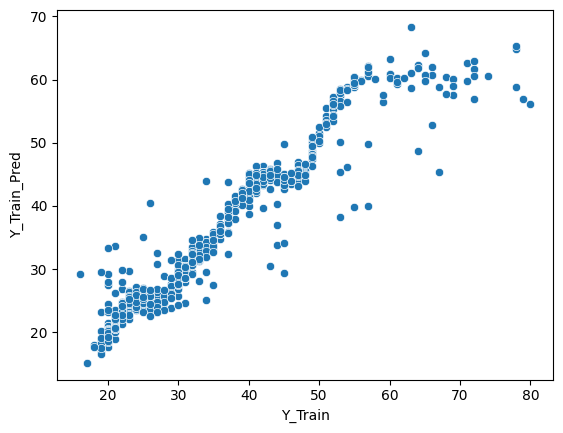

In [17]:
sns.scatterplot(df_train, x = "Y_Train", y="Y_Train_Pred")

/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Y_Test', ylabel='Y_Test_Pred'>

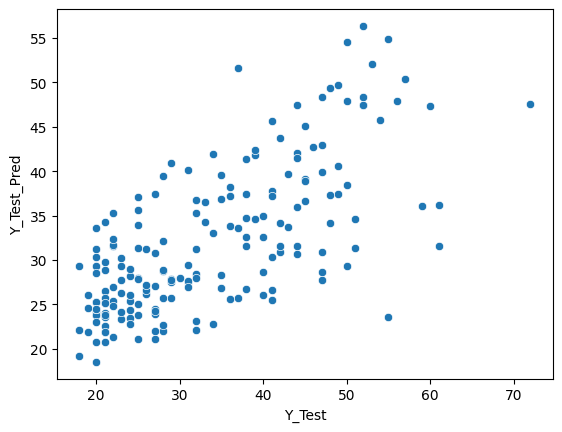

In [18]:
sns.scatterplot(df_test, x = "Y_Test", y="Y_Test_Pred")

In [37]:
df_train

,Y_Train,Y_Train_Pred
0,22.0,22.725731
1,38.0,59.181206
2,50.0,24.009371
3,35.0,27.649929
4,20.0,57.528736
...,...,...
743,25.0,45.094784
744,64.0,22.930145
745,37.0,45.797150
746,30.0,58.373062
